In [63]:
%matplotlib inline
import csv
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import (RandomForestRegressor, IsolationForest)
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import random as rn
import tensorflow as tf
from keras import backend as K
from sklearn.model_selection import StratifiedKFold
import math

TRAIN_FILE_PATH = "data/X_train.csv"
TARGET_FILE_PATH =  "data/y_train.csv"
TEST_FILE_PATH = "data/X_test.csv"

seed=42
np.random.seed(seed)
rn.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)



# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(seed)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)



In [4]:
#Load train and test set

train_data = pd.read_csv(TRAIN_FILE_PATH)
train_data.drop(train_data.columns[0], axis=1, inplace=True)

Y_train = pd.read_csv(TARGET_FILE_PATH)
Y_train.drop(Y_train.columns[0], axis=1, inplace = True)

test_data =  pd.read_csv(TEST_FILE_PATH)
id_test = test_data.columns[0]
test_data.drop(test_data.columns[0], axis=1, inplace=True)

In [5]:
# fill missing values with mean column values train and test set
def fill_NaN(train, test):
    
    print("Train shape: ", train.shape)
    print("Test shape: ",test.shape)
    
    train_mean_values = train.mean()
    train =  train.fillna(train_mean_values)
    test = test.fillna(train_mean_values)
    
    return train,test


In [6]:
train_data_mean, test_data_mean = fill_NaN(train_data, test_data)

Train shape:  (1212, 887)
Test shape:  (776, 887)


In [7]:
def remove_outliers(X_train, Y_train):
    rng = np.random.RandomState(seed)
    isoForest = IsolationForest(behaviour='new', max_samples=100, random_state=rng, contamination='auto')
    outliers = isoForest.fit_predict(X_train)
    print("Removed {} Outliers".format((outliers < 0).sum()))
    X_train["outliers"] = outliers
    X_train = X_train[X_train["outliers"] > 0]
    Y_train["outliers"] = outliers
    Y_train = Y_train[Y_train["outliers"] > 0]
    X_train.drop(["outliers"], axis=1, inplace = True)
    Y_train.drop(["outliers"], axis=1, inplace = True)
    return X_train, Y_train

In [8]:
train_data_mean_no_outlier, Y_train_no_outlier = remove_outliers(train_data_mean, Y_train)
Y_train.drop(["outliers"], axis=1, inplace = True)

Removed 3 Outliers


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
#Zero mean unit variance for train and test data
def scale_data(train, test):
    
    print("Train shape: ", train.shape)
    print("Test shape: ",test.shape)
    
    scaler = StandardScaler().fit(train, Y_train)
    train = scaler.transform(train)
    test = scaler.transform(test)
   
    return train, test

In [10]:
X_train_scaled, X_test_scaled = scale_data(train_data_mean_no_outlier, test_data_mean)

Train shape:  (1209, 887)
Test shape:  (776, 887)


[731 493 523 772 746  82 685 333 882 722 391 751 291   0  96 349 730 363
 687 673 340 185 604 664 838 309 180 686 665 300 297 744 608 156 345 853
  80 490 547 636 470 613 234 120 810 426 430 196 232 370 237 137 142  89
  42 736 332 634 201 111  85 505 554 871 460 229 224 520 560  83 372 205
 735 666 643  52 556 607 273   5 646 644  94 633 335 741 739 298 398 186
 637 266 787 840 251 615 716 618  88 484 326 388 158 833 638 632 605 794
 660 652 609 791 752 299 763 371 504   7 367  28 198 275 351 424 804 870
 697 277 879 450 374 795  32 611  66 599 369 781 457 823 151 844 269  20
 135 479 209 315 166 283]
150


/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  c

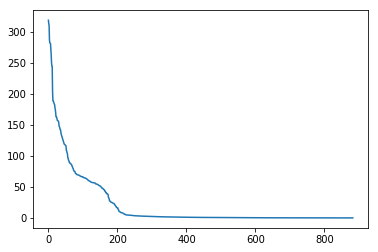

In [11]:
#Extract the features to use with f_regression

n_features_fr = 150

features_scores = f_regression(X_train_scaled, Y_train_no_outlier)[0]
#print(features_scores)
y = list(features_scores)
myarray = np.asarray(y)

plt.plot(-1*np.sort(-1*myarray));

indices_fr = myarray.argsort()[-n_features_fr:][::-1]
print(indices_fr)
print(len(indices_fr))



/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


[ 96 685 722  82 664 751 291 746 882 499 604  80 391 349 810 470 687 237
 686 173  89 870 309 665 763 853 529 273 340 283 651 547 224 300 803 185
 186 730   0 823 560 838 126 351 591 386 618 137 400 449 479 632 363 816
 840 831 198 787 673 636 739 299  12 613 554 660 151 229 779 457 599 290
 559 818  85 192 735   5 743 374 443 264 697 426 445 644 643 666 142 381
 582  34  42 350 826  15  83 450 372 716]


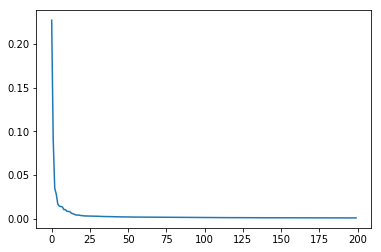

In [12]:
#Extract feature importance of Random Forest & find intersection/union with f_regression ones

n_features_rf = 100
rng = np.random.RandomState(seed)
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, random_state=rng)
rf.fit(X_train_scaled,Y_train_no_outlier)

scores = list(rf.feature_importances_)
my_rf_features = np.asarray(scores)

plt.plot((-1*np.sort(-1*my_rf_features))[0:200]);

indices_rf = my_rf_features.argsort()[-n_features_rf:][::-1]

print(indices_rf)
#print(-1*np.sort(-1*rf.feature_importances_));


In [13]:
# Find intersection/union between best f_regression features and random forest's

#print(set(indices_rf).intersection(indices_fr))
#indices = set(indices_rf).intersection(indices_fr)

indices = list(np.union1d(indices_rf, indices_fr))
print(len(indices))

178


In [66]:
#Extract the feature selected from dataset

#indices = indices_rf
#indices = indices_fr

X_train_subset = train_data_mean[train_data_mean.columns[indices]]
X_test_subset = test_data_mean[train_data_mean.columns[indices]]


X_train_subset, X_test_subset = fill_NaN(X_train_subset, X_test_subset)
X_train_subset, X_test_subset = scale_data(X_train_subset, X_test_subset)

print(X_train_subset.shape)

Train shape:  (1212, 178)
Test shape:  (776, 178)
Train shape:  (1212, 178)
Test shape:  (776, 178)
(1212, 178)


In [76]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers
from keras import initializers

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# fix random seed for reproducibility
# Parameters

input_dimensions = len(indices)
#initializer = initializers.glorot_normal(seed=1)
lambda_reg = 2
Y = Y_train.values
num_epochs = 100
dropout = 0.2

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

for train, test in kfold.split(X_train_subset, Y):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim= input_dimensions, kernel_regularizer = regularizers.l2(lambda_reg)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(rate = dropout))

    model.add(Dense(1, kernel_regularizer = regularizers.l1(lambda_reg)))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[coeff_determination])

    # Fit the model
    model.fit(x=X_train_subset[train], y=Y[train], epochs=num_epochs, verbose=0, validation_split=0.1, shuffle=True, 
              steps_per_epoch=100, initial_epoch=0, validation_steps=5)

    # evaluate the model
    scores = model.evaluate(X_train_subset[test], Y[test], verbose=0)
    print("R_2 score = {}".format(scores[1]))
    cvscores.append(scores)

metrics = [m[1] for m in cvscores]
print("AVG: R2 score: %.4f (+/- %.4f)" % (np.mean(metrics), np.std(metrics)))

/home/ax/miniconda3/envs/aml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


R_2 score = 0.4140816225725062
R_2 score = 0.29289000930515585
R_2 score = 0.48371848775379694
R_2 score = 0.3874571894256162
R_2 score = 0.45488291732535874
R_2 score = 0.3577768364523211
R_2 score = 0.24749304285836876
R_2 score = 0.3530409711378592
R_2 score = 0.32370660645621163
R_2 score = 0.4199466554805486
AVG: R2 score: 0.3735 (+/- 0.0695)


Min val: 0.587761640548706
Last val: 0.5599937438964844


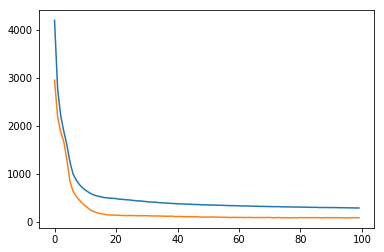

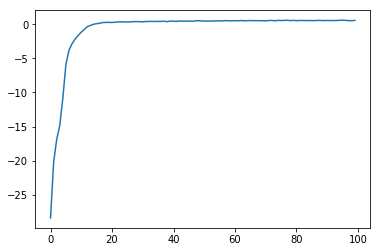

In [59]:
# visualizing losses and accuracy
train_loss = seqModel.history['loss']
val_loss   = seqModel.history['val_loss']
val_coeff_determination  = seqModel.history['val_coeff_determination']
xc         = range(num_epochs)

#Min val: 0.6423026919364929
# Last val: 0.6423026919364929

plt.plot(xc, train_loss);
plt.plot(xc, val_loss);
print("Min val: {}".format(np.max(val_coeff_determination)))
print("Last val: {}".format(val_coeff_determination[-1]))
plt.figure()
plt.plot(xc, val_coeff_determination);


In [37]:
#Predict on test set
predictions = model.predict(X_test_subset)


[[75.78825 ]
 [70.791016]
 [68.12141 ]
 [68.40366 ]
 [70.90145 ]
 [67.24303 ]
 [79.989746]
 [67.714905]
 [73.310234]
 [61.786804]
 [70.027466]
 [65.72696 ]
 [66.06811 ]
 [68.88675 ]
 [70.32245 ]
 [70.204704]
 [63.88546 ]
 [75.380486]
 [64.41486 ]
 [65.89705 ]
 [64.376076]
 [64.54071 ]
 [74.26534 ]
 [65.60742 ]
 [68.51535 ]
 [61.292053]
 [62.33145 ]
 [77.72175 ]
 [81.9335  ]
 [70.76523 ]
 [58.589523]
 [64.5142  ]
 [61.78582 ]
 [65.542755]
 [64.9394  ]
 [68.99081 ]
 [73.154755]
 [61.32441 ]
 [67.86541 ]
 [71.84517 ]
 [68.860954]
 [69.87808 ]
 [66.667015]
 [68.91196 ]
 [67.56796 ]
 [62.587585]
 [76.55645 ]
 [70.99911 ]
 [71.60235 ]
 [73.02955 ]
 [64.238075]
 [63.801857]
 [61.09562 ]
 [63.93416 ]
 [65.5166  ]
 [67.037   ]
 [79.99452 ]
 [59.48519 ]
 [64.83139 ]
 [68.64711 ]
 [75.97903 ]
 [74.384285]
 [75.972   ]
 [66.33517 ]
 [67.12427 ]
 [69.11149 ]
 [73.11118 ]
 [73.916336]
 [60.436127]
 [64.09543 ]
 [66.59161 ]
 [69.11752 ]
 [77.47893 ]
 [72.57387 ]
 [58.937225]
 [64.86406 ]
 [67.28141 ]

In [38]:
#Prepare predictions to be wirtten to csv
filename = "ax_keras_20.csv"
test_data =  pd.read_csv(TEST_FILE_PATH)
test_data["y"] = predictions
test_data[["id", "y"]].to_csv("submissions/"+filename, index= False)

#print(y_pred)

In [31]:
# load the predictions and try to round them
pred_1 =  pd.read_csv("submissions/best.csv")

def round_function(x):
    frac, whole = math.modf(x)
    lim = 0.1
    # round down 
    if np.abs(frac) < lim:
        return whole
    # round up
    if np.abs(frac) > 1.0 - lim:
        return whole + 1
    return x

pred_1["y"] = pred_1["y"].apply(round_function)
pred_1[["id", "y"]].to_csv("submissions/best_rounded.csv", index= False)

